In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.6 MB/s 


# Vision Transformers

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa

## Download Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()
print('x_train shape', x_train.shape)
print('y_train shape', y_train.shape)
print('x_test shape', x_test.shape)
print('y_test shape', y_test.shape)

169017344/169001437 [==============================] - 2s 0us/step
x_train shape (50000, 32, 32, 3)
y_train shape (50000, 1)
x_test shape (10000, 32, 32, 3)
y_test shape (10000, 1)


In [4]:
num_classes = 100
input_shape = (32, 32, 3)
image_size = 72
num_epochs = 30

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
patch_size = 6
projection_dim = 64
num_heads = 4
num_patches = (image_size // patch_size) ** 2
transformer_units = [
    projection_dim * 2,
    projection_dim
]
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [5]:
train_im, val_im, train_label, val_label = train_test_split(x_train, y_train, test_size=.2, stratify=y_train, random_state=42, shuffle=True)

unique, counts = np.unique(train_label, return_counts=True)
print('Train labels', dict(zip(unique, counts)))

unique, counts = np.unique(val_label, return_counts=True)
print('Validation labels', dict(zip(unique, counts)))

Train labels {0: 400, 1: 400, 2: 400, 3: 400, 4: 400, 5: 400, 6: 400, 7: 400, 8: 400, 9: 400, 10: 400, 11: 400, 12: 400, 13: 400, 14: 400, 15: 400, 16: 400, 17: 400, 18: 400, 19: 400, 20: 400, 21: 400, 22: 400, 23: 400, 24: 400, 25: 400, 26: 400, 27: 400, 28: 400, 29: 400, 30: 400, 31: 400, 32: 400, 33: 400, 34: 400, 35: 400, 36: 400, 37: 400, 38: 400, 39: 400, 40: 400, 41: 400, 42: 400, 43: 400, 44: 400, 45: 400, 46: 400, 47: 400, 48: 400, 49: 400, 50: 400, 51: 400, 52: 400, 53: 400, 54: 400, 55: 400, 56: 400, 57: 400, 58: 400, 59: 400, 60: 400, 61: 400, 62: 400, 63: 400, 64: 400, 65: 400, 66: 400, 67: 400, 68: 400, 69: 400, 70: 400, 71: 400, 72: 400, 73: 400, 74: 400, 75: 400, 76: 400, 77: 400, 78: 400, 79: 400, 80: 400, 81: 400, 82: 400, 83: 400, 84: 400, 85: 400, 86: 400, 87: 400, 88: 400, 89: 400, 90: 400, 91: 400, 92: 400, 93: 400, 94: 400, 95: 400, 96: 400, 97: 400, 98: 400, 99: 400}
Validation labels {0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 100, 6: 100, 7: 100, 8: 100, 9: 10

In [6]:
training_data = tf.data.Dataset.from_tensor_slices((train_im, train_label))
validation_data = tf.data.Dataset.from_tensor_slices((val_im, val_label))
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

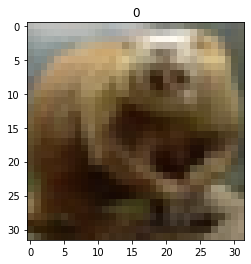

In [7]:
sample_data = next(iter(training_data))
plt.figure()
plt.imshow(sample_data[0])
plt.title(np.argmax(sample_data[1]))
plt.show()

In [8]:
train_data_batches = training_data.shuffle(buffer_size=40000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_data_batches = validation_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data_batches = test_data.shuffle(buffer_size=10000).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

## Patch Generation

### Keras blog

In [9]:
class generate_patch(tf.keras.layers.Layer):
  def __init__(self, patch_size):
    super(generate_patch, self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(
        images=images,
        sizes=[1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

In [10]:
train_iter_im, train_iter_label = next(iter(training_data))
train_iter_im = tf.expand_dims(train_iter_im, 0)
train_iter_label = train_iter_label.numpy()

In [11]:
generate_patch_layer = generate_patch(patch_size=patch_size)
patches = generate_patch_layer(train_iter_im)
print(patches.shape)

(1, 25, 108)


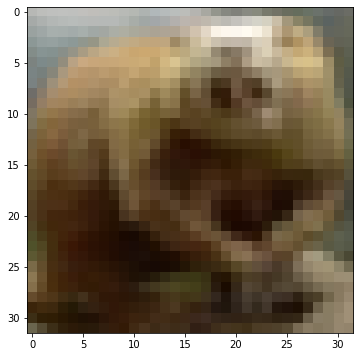

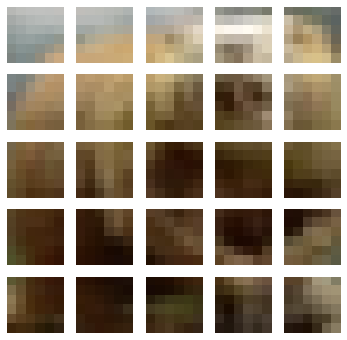

In [12]:
def render_image_and_patches(image, patches, patch_size):
  plt.figure(figsize=(6, 6))
  plt.imshow(tf.cast(image[0], tf.uint8))
  n = int(np.sqrt(patches.shape[1]))
  plt.figure(figsize=(6, 6))
  for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    ax.imshow(patch_img.numpy().astype('uint8'))
    ax.axis('off')

render_image_and_patches(train_iter_im, patches, patch_size)

In [13]:
class PatchEncoder(tf.keras.layers.Layer):
  def __init__(self, num_patches, projection_dim, log=False):
    super(PatchEncoder, self).__init__()
    self.num_patches = num_patches
    self.projection = tf.keras.layers.Dense(units=projection_dim)
    self.position_embedding = tf.keras.layers.Embedding(
        input_dim=num_patches, output_dim=projection_dim
    )
    self.log = log
  
  def call(self, patch):
    positions = tf.range(start=0, limit=self.num_patches, delta=1)
    if self.log:
      print('patch input shape:', patch.shape)
      print('positions:', positions)
      print('embedding:', self.position_embedding(positions).shape)
    encoded = self.projection(patch) + self.position_embedding(positions)
    return encoded

In [14]:
patch_encode_embed = PatchEncoder(num_patches=patches.shape[1], projection_dim=768, log=True)
path_encoded = patch_encode_embed(patches)
print('Output shape:', path_encoded.shape)

patch input shape: (1, 25, 108)
positions: tf.Tensor(
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24], shape=(25,), dtype=int32)
embedding: (25, 768)
Output shape: (1, 25, 768)


## Build the ViT Model

In [15]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.Normalization(),
        tf.keras.layers.Resizing(image_size, image_size),
        tf.keras.layers.RandomFlip('horizontal'),
        tf.keras.layers.RandomRotation(factor=0.02),
        tf.keras.layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name='data_augmentation',
)

data_augmentation.layers[0].adapt(x_train)

def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = tf.keras.layers.Dense(units=units, activation=tf.nn.gelu)(x)
    x = tf.keras.layers.Dropout(rate=dropout_rate)(x)
  return x

In [16]:
def create_vit_classifier():
  inputs = tf.keras.layers.Input(shape=input_shape)
  augmented = data_augmentation(inputs)
  patches = generate_patch(patch_size=patch_size)(augmented)
  
  encoded_patches = PatchEncoder(num_patches=num_patches, projection_dim=projection_dim)(patches)

  # Create multiple layers of the Transformer block
  for _ in range(transformer_layers):
    x1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    attention_output = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=.1
    )(x1, x1)
    x2 = tf.keras.layers.Add()([attention_output, encoded_patches])
    x3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=.1)
    encoded_patches = tf.keras.layers.Add()([x3, x2])

  # Create a [batch_size, projection_dim] tensor
  representation = tf.keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = tf.keras.layers.Flatten()(representation)
  representation = tf.keras.layers.Dropout(.5)(representation)

  # MLP
  features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
  logits = tf.keras.layers.Dense(num_classes)(features)

  model = tf.keras.Model(inputs=inputs, outputs=logits)
  return model

model = create_vit_classifier()

In [17]:
output_sample = model(train_iter_im)
output_sample.shape

TensorShape([1, 100])

##Compile and train the model

In [18]:
def run_experiment(model):
  optimizer = tfa.optimizers.AdamW(
      weight_decay=weight_decay,
      learning_rate=learning_rate
  )

  model.compile(
      optimizer=optimizer,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[
               tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy'),
               tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name='top5-accuracy')
      ]
  )

  checkpoint_filepath = '/tmp/checkpoint'
  checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      checkpoint_filepath,
      save_best_only=True,
      save_weights_only=True
  )

  # history = model.fit(
  #     train_data_batches,
  #     epochs=num_epochs,
  #     validation_data=valid_data_batches,
  #     callbacks=[checkpoint_callback]
  # )  

  history = model.fit(
      x=x_train,
      y=y_train,
      batch_size=batch_size,
      epochs=num_epochs,
      validation_split=0.1,
      callbacks=[checkpoint_callback]
  )

  model.load_weights(checkpoint_filepath)
  _, accuracy, top_5_accuracy = model.evaluate(test_data_batches)
  print('Test accuracy: {}%'.format(round(accuracy * 100, 2)))
  print('Test top 5 accuracy: {}%'.format(round(top_5_accuracy * 100, 2)))
  return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/30
176/176 [==============================] - 68s 334ms/step - loss: 4.5148 - accuracy: 0.0310 - top5-accuracy: 0.1244 - val_loss: 4.0965 - val_accuracy: 0.0732 - val_top5-accuracy: 0.2550
Epoch 2/30
176/176 [==============================] - 59s 336ms/step - loss: 4.1267 - accuracy: 0.0636 - top5-accuracy: 0.2225 - val_loss: 3.7532 - val_accuracy: 0.1178 - val_top5-accuracy: 0.3490
Epoch 3/30
176/176 [==============================] - 60s 342ms/step - loss: 3.8974 - accuracy: 0.0948 - top5-accuracy: 0.2954 - val_loss: 3.5558 - val_accuracy: 0.1574 - val_top5-accuracy: 0.4130
Epoch 4/30
176/176 [==============================] - 61s 344ms/step - loss: 3.7511 - accuracy: 0.1179 - top5-accuracy: 0.3405 - val_loss: 3.3755 - val_accuracy: 0.1846 - val_top5-accuracy: 0.4684
Epoch 5/30
176/176 [==============================] - 60s 343ms/step - loss: 3.5965 - accuracy: 0.1414 - top5-accuracy: 0.3848 - val_loss: 3.2704 - val_accuracy: 0.2088 - val_top5-accuracy: 0.4950
Epoch 6/30
176/

## Plot results

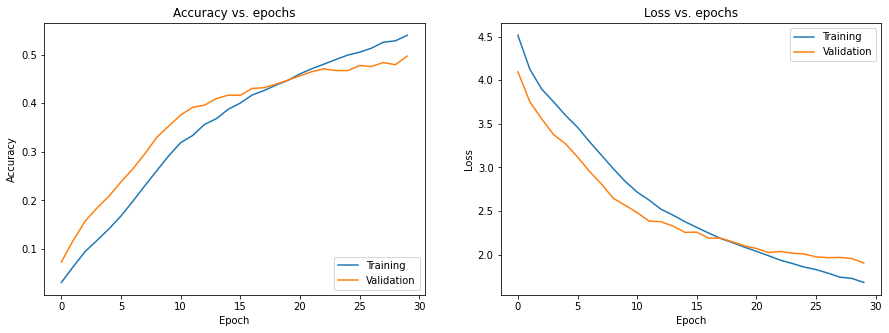

In [19]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [21]:
vit_classifier.evaluate(x_test, y_test)

313/313 [==============================] - 7s 21ms/step - loss: 1.8730 - accuracy: 0.5030 - top5-accuracy: 0.7876


[1.8730049133300781, 0.503000020980835, 0.7875999808311462]